In [7]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import pymc3 as pm
from scipy.special import expit

import matplotlib.pyplot as plt

In [2]:
sizes = [50, 100, 200, 400, 800, 1600, 2700]
models = ["ML_logreg", "L2_logreg", "Bayesian_logreg",
          "naive_bayes", "decision_tree", "random_forest"]
scores = pd.DataFrame(columns=models, index=sizes)
for i in sizes:
    train = pd.read_csv(f"../data/league_train_{i}.csv")
    test = pd.read_csv(f"../data/league_test_{i}.csv")
    f_cols = [col for col in train.columns if col not in ["matchId", "blue_win"]]
    mms = MinMaxScaler(feature_range=(0.001, 0.999))
    X_train = mms.fit_transform(train[f_cols])
    y_train = train["blue_win"].values
    X_test = mms.transform(test[f_cols])
    y_test = test["blue_win"].values
    
    clf = LogisticRegression(random_state=0, C=1.).fit(X_train, y_train)
    preds_test = clf.predict_proba(X_test)
    print(f"ML logreg AUC score: {roc_auc_score(y_test, np.argmax(preds_test, axis=1))}")
    scores.loc[i, "ML_logreg"] = roc_auc_score(y_test, np.argmax(preds_test, axis=1))
    clf = LogisticRegression(random_state=0, C=0.3).fit(X_train, y_train)
    preds_test = clf.predict_proba(X_test)
    print(f"L2 logreg AUC score: {roc_auc_score(y_test, np.argmax(preds_test, axis=1))}")
    scores.loc[i, "L2_logreg"] = roc_auc_score(y_test, np.argmax(preds_test, axis=1))

    
    with pm.Model() as model:
        # Alpha is the interception
        alpha = pm.Normal("alpha", mu=0, sd=10)
        # The prior for the features varibles which are included
        #beta = pm.Normal("beta", mu=0, sd=3, shape=X.shape[1])
        b_gold = pm.Beta("b_gold", alpha=3, beta=3, observed=X_train[:,f_cols.index("blueGold")])
        b_minion = pm.Beta("b_minion", alpha=3, beta=3, observed=X_train[:,f_cols.index("blueMinionsKilled")])
        b_jungle_camps = pm.Beta("b_camps", alpha=3, beta=3, observed=X_train[:,f_cols.index("blueJungleMinionsKilled")])
        b_avg_level = pm.Beta("b_level", alpha=3, beta=3, observed=X_train[:,f_cols.index("blueAvgLevel")])
        b_champ_kills = pm.Beta("b_kills", alpha=3, beta=3, observed=X_train[:,f_cols.index("blueChampKills")])
        b_towers_destroyed = pm.Beta("b_towers", alpha=3, beta=5, observed=X_train[:,f_cols.index("blueTowersDestroyed")])
        b_herald_kills = pm.Beta("b_heralds", alpha=3, beta=5, observed=X_train[:,f_cols.index("blueHeraldKills")])

        r_gold = pm.Beta("r_gold", alpha=3, beta=3, observed=X_train[:,f_cols.index("redGold")])
        r_minion = pm.Beta("r_minion", alpha=3, beta=3, observed=X_train[:,f_cols.index("redMinionsKilled")])
        r_jungle_camps = pm.Beta("r_camps", alpha=3, beta=3, observed=X_train[:,f_cols.index("redJungleMinionsKilled")])
        r_avg_level = pm.Beta("r_level", alpha=3, beta=3, observed=X_train[:,f_cols.index("redAvgLevel")])
        r_champ_kills = pm.Beta("r_kills", alpha=3, beta=3, observed=X_train[:,f_cols.index("redChampKills")])
        r_towers_destroyed = pm.Beta("r_towers", alpha=3, beta=5, observed=X_train[:,f_cols.index("redTowersDestroyed")])
        r_herald_kills = pm.Beta("r_heralds", alpha=3, beta=5, observed=X_train[:,f_cols.index("redHeraldKills")])

        #beta = pm.Normal("beta", mu=0, sd=10, shape=X_train.shape[1])
        beta_b_gold = pm.Normal("beta_b_gold", mu=6, sd=3)
        beta_b_minion = pm.Normal("beta_b_minion", mu=2, sd=1)
        beta_b_jungle_camps = pm.Normal("beta_b_camps", mu=2, sd=1)
        beta_b_avg_level = pm.Normal("beta_b_level", mu=2, sd=1)
        beta_b_champ_kills = pm.Normal("beta_b_kills", mu=2, sd=1)
        beta_b_towers_destroyed = pm.Normal("beta_b_towers", mu=2, sd=1)
        beta_b_herald_kills = pm.Normal("beta_b_heralds", mu=2, sd=1)


        beta_r_gold = pm.Normal("beta_r_gold", mu=-6, sd=3)
        beta_r_minion = pm.Normal("beta_r_minion", mu=-2, sd=1)
        beta_r_jungle_camps = pm.Normal("beta_r_camps", mu=-2, sd=1)
        beta_r_avg_level = pm.Normal("beta_r_level", mu=-2, sd=1)
        beta_r_champ_kills = pm.Normal("beta_r_kills", mu=-2, sd=1)
        beta_r_towers_destroyed = pm.Normal("beta_r_towers", mu=-2, sd=1)
        beta_r_herald_kills = pm.Normal("beta_r_heralds", mu=-2, sd=1)

        # Deterministic function
        #p = pm.math.dot(X,beta)
        p = (b_gold * beta_b_gold +
             b_minion * beta_b_minion +
             b_jungle_camps * beta_b_jungle_camps +
             b_avg_level * beta_b_avg_level +
             b_champ_kills * beta_b_champ_kills +
             b_towers_destroyed * beta_b_towers_destroyed +
             b_herald_kills * beta_b_herald_kills +
             r_gold * beta_r_gold +
             r_minion * beta_r_minion +
             r_jungle_camps * beta_r_jungle_camps +
             r_avg_level * beta_r_avg_level +
             r_champ_kills * beta_r_champ_kills +
             r_towers_destroyed * beta_r_towers_destroyed +
             r_herald_kills * beta_r_herald_kills
            )

        y_obs = pm.Bernoulli("y_obs", pm.invlogit(p + alpha), observed=y_train)
        trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
        results = pd.DataFrame({'beta_b_gold':np.apply_along_axis(np.mean, 0, trace['beta_b_gold']),
                        'beta_b_minion':np.apply_along_axis(np.mean, 0, trace['beta_b_minion']),
                        'beta_b_camps':np.apply_along_axis(np.mean, 0, trace['beta_b_camps']),
                        'beta_b_level':np.apply_along_axis(np.mean, 0, trace['beta_b_level']),
                        'beta_b_kills':np.apply_along_axis(np.mean, 0, trace['beta_b_kills']),
                        'beta_b_towers':np.apply_along_axis(np.mean, 0, trace['beta_b_towers']),
                        'beta_b_heralds': np.apply_along_axis(np.mean, 0, trace['beta_b_heralds']),
                        'beta_r_gold':np.apply_along_axis(np.mean, 0, trace['beta_r_gold']),
                        'beta_r_minion':np.apply_along_axis(np.mean, 0, trace['beta_r_minion']),
                        'beta_r_camps':np.apply_along_axis(np.mean, 0, trace['beta_r_camps']),
                        'beta_r_level':np.apply_along_axis(np.mean, 0, trace['beta_r_level']),
                        'beta_r_kills':np.apply_along_axis(np.mean, 0, trace['beta_r_kills']),
                        'beta_r_towers':np.apply_along_axis(np.mean, 0, trace['beta_r_towers']),
                        'beta_r_heralds': np.apply_along_axis(np.mean, 0, trace['beta_r_heralds']),
                        'alpha':np.apply_along_axis(np.mean, 0, trace['alpha'])
                       }, index=[0])
        preds_test = np.apply_along_axis(np.mean, 1, expit(trace['alpha'] + np.dot(X_test, np.transpose(results.drop("alpha", axis=1)) )) )
        print(f"Bayesian logreg AUC score: {roc_auc_score(y_test, preds_test)}")
        scores.loc[i, "Bayesian_logreg"] = roc_auc_score(y_test, preds_test)
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    preds_test = gnb.predict(X_test)
    print(f"NB AUC score: {roc_auc_score(y_test, preds_test)}")
    scores.loc[i, "naive_bayes"] = roc_auc_score(y_test, preds_test)
    
    folds = StratifiedKFold(n_splits=5, shuffle=True)
    dtc = DecisionTreeClassifier()
    parameter_grid = {'max_features': [5,6,7,8,9,10,11,12,13,14],
                      'max_depth': [2,3, 4, 5, 6, 7, 8, 9, 10]
                     }
    grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    dtc = DecisionTreeClassifier(**grid_search.best_params_).fit(X_train,y_train)
    preds_test = dtc.predict_proba(X_test)[:,1]
    print(f"DT AUC score: {roc_auc_score(y_test, preds_test)}")
    scores.loc[i, "decision_tree"] = roc_auc_score(y_test, preds_test)
    
    rfc = RandomForestClassifier()
    parameter_grid = {'max_features': [5,6,7,8,9,10,11,12,13,14],
                      'max_depth': [2,3, 4, 5, 6, 7, 8, 9, 10]
                     }
    grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    rfc = RandomForestClassifier(**grid_search.best_params_).fit(X_train,y_train)
    preds_test = rfc.predict_proba(X_test)[:,1]
    print(f"RF AUC score: {roc_auc_score(y_test, preds_test)}")
    scores.loc[i, "random_forest"] = roc_auc_score(y_test, preds_test)

ML logreg AUC score: 0.774102782954496
L2 logreg AUC score: 0.7787664563120565


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.8149395516466748
NB AUC score: 0.7672811850064212
DT AUC score: 0.7006352284867349
RF AUC score: 0.8368456883598487
ML logreg AUC score: 0.771626393562527
L2 logreg AUC score: 0.7771938296985689


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.7914762920915352
NB AUC score: 0.7686986232015416
DT AUC score: 0.7681290922315307
RF AUC score: 0.8322220847887316
ML logreg AUC score: 0.7723455298771629
L2 logreg AUC score: 0.7803258575230128


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.7966185376972781
NB AUC score: 0.7784777457525112
DT AUC score: 0.786082176221488
RF AUC score: 0.8407439491296586
ML logreg AUC score: 0.7817701537829975
L2 logreg AUC score: 0.7828541927459606


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.8060160260613154
NB AUC score: 0.7815720826848079
DT AUC score: 0.8059863759237288
RF AUC score: 0.8595538020205354
ML logreg AUC score: 0.7827625875917511
L2 logreg AUC score: 0.7841553872906288


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 77 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.8017903581465122
NB AUC score: 0.7822949449458321
DT AUC score: 0.8188111763230855
RF AUC score: 0.8628659098850768
ML logreg AUC score: 0.7855432361545278
L2 logreg AUC score: 0.7858866685099579


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 138 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.8391971857559115
NB AUC score: 0.7832759945856925
DT AUC score: 0.826341957657364
RF AUC score: 0.8655056165249627
ML logreg AUC score: 0.7858463008575559
L2 logreg AUC score: 0.7862940853093073


<ipython-input-2-99b719ce7225>:83: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=2000, draws = 2000, random_seed = 0, cores = 1, progressbar = True, chains = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [beta_r_heralds, beta_r_towers, beta_r_kills, beta_r_level, beta_r_camps, beta_r_minion, beta_r_gold, beta_b_heralds, beta_b_towers, beta_b_kills, beta_b_level, beta_b_camps, beta_b_minion, beta_b_gold, alpha]


Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 223 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Bayesian logreg AUC score: 0.8476255268980749
NB AUC score: 0.7832314844470877
DT AUC score: 0.8459175667214511
RF AUC score: 0.8667092204546593


In [3]:
scores

,ML_logreg,L2_logreg,Bayesian_logreg,naive_bayes,decision_tree,random_forest
50,0.774103,0.778766,0.81494,0.767281,0.700635,0.836846
100,0.771626,0.777194,0.791476,0.768699,0.768129,0.832222
200,0.772346,0.780326,0.796619,0.778478,0.786082,0.840744
400,0.78177,0.782854,0.806016,0.781572,0.805986,0.859554
800,0.782763,0.784155,0.80179,0.782295,0.818811,0.862866
1600,0.785543,0.785887,0.839197,0.783276,0.826342,0.865506
2700,0.785846,0.786294,0.847626,0.783231,0.845918,0.866709


<Figure size 432x288 with 0 Axes>

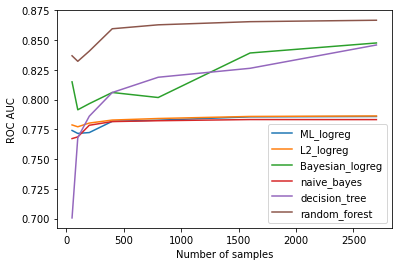

In [10]:
plt.tight_layout()
scores.plot(xlabel="Number of samples", ylabel="ROC AUC")
plt.savefig("league_sample_sizes.png")